In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import pandas as pd
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

import os

In [2]:
!unzip -q /content/drive/MyDrive/Datasets/multi_digit_mnist/multi_digit_mnist.zip

replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace test_images/0_02.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace test_images/0_17.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [3]:
df_train= pd.read_csv('/content/train.csv')
df_test= pd.read_csv('/content/test.csv')

In [4]:
df_train

,Image,first_num,second_num
0,0_00.png,0,0
1,100_00.png,0,0
2,101_00.png,0,0
3,102_00.png,0,0
4,103_00.png,0,0
...,...,...,...
63995,997_98.png,9,8
63996,998_98.png,9,8
63997,999_98.png,9,8
63998,99_98.png,9,8


First num: 6, second num: 5


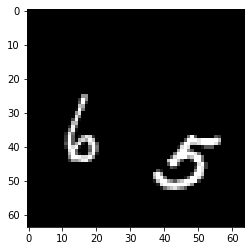

In [5]:
row= 42069

# temp_img= tf.io.read_file(os.path.join('train_images', df_train.iloc[row,0]))
# temp_img= tf.image.decode_image(temp_img, channels=1, dtype=tf.float32)
# temp_img= cv.merge((temp_img.numpy(), temp_img.numpy(), temp_img.numpy()))

temp_img= cv.imread(os.path.join('train_images', df_train.iloc[row,0]))

print(f'First num: {df_train.iloc[row,1]}, second num: {df_train.iloc[row,2]}')
plt.imshow(temp_img)
plt.show()

In [17]:
TRAIN_PATH= '/content/train_images/'
TEST_PATH= '/content/test_images/'

BATCH_SIZE= 64
AUTOTUNE= tf.data.experimental.AUTOTUNE
LR= 0.0001
WEIGHT_DECAY= 0.001

In [7]:
train_images= TRAIN_PATH + df_train.iloc[:,0].values
train_labels= df_train.iloc[:,1:].values

test_images= TEST_PATH + df_test.iloc[:,0].values
test_labels= df_test.iloc[:,1:].values

train_images

array(['/content/train_images/0_00.png',
       '/content/train_images/100_00.png',
       '/content/train_images/101_00.png', ...,
       '/content/train_images/999_98.png',
       '/content/train_images/99_98.png',
       '/content/train_images/9_98.png'], dtype=object)

In [18]:
def load_data(img_dir, labels):
    img= tf.io.read_file(img_dir)
    img= tf.image.decode_image(img, channels=1, dtype=tf.float32)

    labels= {'first_number': labels[0], 'second_number': labels[1]}

    return img, labels

In [19]:
train_data= tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_data= train_data.shuffle(len(train_images)).map(load_data).batch(BATCH_SIZE).prefetch(AUTOTUNE)

test_data= tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_data= test_data.shuffle(len(test_images)).map(load_data).batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [20]:
class CNN_Block(layers.Layer):
    def __init__(self, channel_size=64, kernel=3, padding='same', batch_norm=True, regularizers=None):
        super(CNN_Block, self).__init__()

        self.cnnl= layers.Conv2D(channel_size, kernel, padding=padding, kernel_regularizer=regularizers)
        self.bn= layers.BatchNormalization()
        self.is_batch_norm= batch_norm

    def call(self, input_tensor):
        x= self.cnnl(input_tensor)

        if self.is_batch_norm:
            x= self.bn(x)

        x= tf.nn.relu(x)

        return x

In [30]:
input= keras.Input((64, 64, 1))
x= CNN_Block(32, regularizers=keras.regularizers.l2(WEIGHT_DECAY))(input)
x= CNN_Block(64)(x)
x= layers.MaxPool2D()(x)
x= CNN_Block(128, regularizers=keras.regularizers.l2(WEIGHT_DECAY))(x)
x= layers.MaxPool2D()(x)
x= CNN_Block(128)(x)
x= layers.Flatten()(x)
x= layers.Dense(128, 'relu')(x)
x= layers.Dropout(0.3)(x)
x= layers.Dense(64, 'relu')(x)
# x= layers.Dropout(0.25)(x)

output1= layers.Dense(10, 'softmax', name='first_number')(x)
output2= layers.Dense(10, 'softmax', name='second_number')(x)

model= keras.Model(inputs= input, outputs= [output1, output2])
model.compile(optimizer=keras.optimizers.Adam(LR), loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [31]:
reduce_lr= keras.callbacks.ReduceLROnPlateau(monitor='first_number_accuracy', factor= 0.75, patience=2, min_lr=0.0001, min_delta=0.005)

history= model.fit(train_data, epochs=20, callbacks=[reduce_lr], validation_data=test_data)

Epoch 1/20
1000/1000 [==============================] - 38s 37ms/step - loss: 2.3302 - first_number_loss: 1.1295 - second_number_loss: 1.1165 - first_number_accuracy: 0.6101 - second_number_accuracy: 0.6132 - val_loss: 1.8662 - val_first_number_loss: 0.5766 - val_second_number_loss: 1.2078 - val_first_number_accuracy: 0.8163 - val_second_number_accuracy: 0.6065 - lr: 1.0000e-04
Epoch 2/20
1000/1000 [==============================] - 37s 37ms/step - loss: 0.7985 - first_number_loss: 0.3601 - second_number_loss: 0.3582 - first_number_accuracy: 0.8817 - second_number_accuracy: 0.8821 - val_loss: 1.6142 - val_first_number_loss: 0.4234 - val_second_number_loss: 1.1121 - val_first_number_accuracy: 0.8643 - val_second_number_accuracy: 0.6685 - lr: 1.0000e-04
Epoch 3/20
1000/1000 [==============================] - 38s 37ms/step - loss: 0.5433 - first_number_loss: 0.2339 - second_number_loss: 0.2324 - first_number_accuracy: 0.9245 - second_number_accuracy: 0.9235 - val_loss: 1.5404 - val_first_

In [32]:
model.evaluate(test_data)

313/313 [==============================] - 6s 19ms/step - loss: 1.3072 - first_number_loss: 0.3216 - second_number_loss: 0.9455 - first_number_accuracy: 0.9175 - second_number_accuracy: 0.8180


[1.3072081804275513,
 0.32157063484191895,
 0.9455406069755554,
 0.9175000190734863,
 0.8180000185966492]

In [33]:
history= history.history

In [34]:
history.keys()

dict_keys(['loss', 'first_number_loss', 'second_number_loss', 'first_number_accuracy', 'second_number_accuracy', 'val_loss', 'val_first_number_loss', 'val_second_number_loss', 'val_first_number_accuracy', 'val_second_number_accuracy', 'lr'])

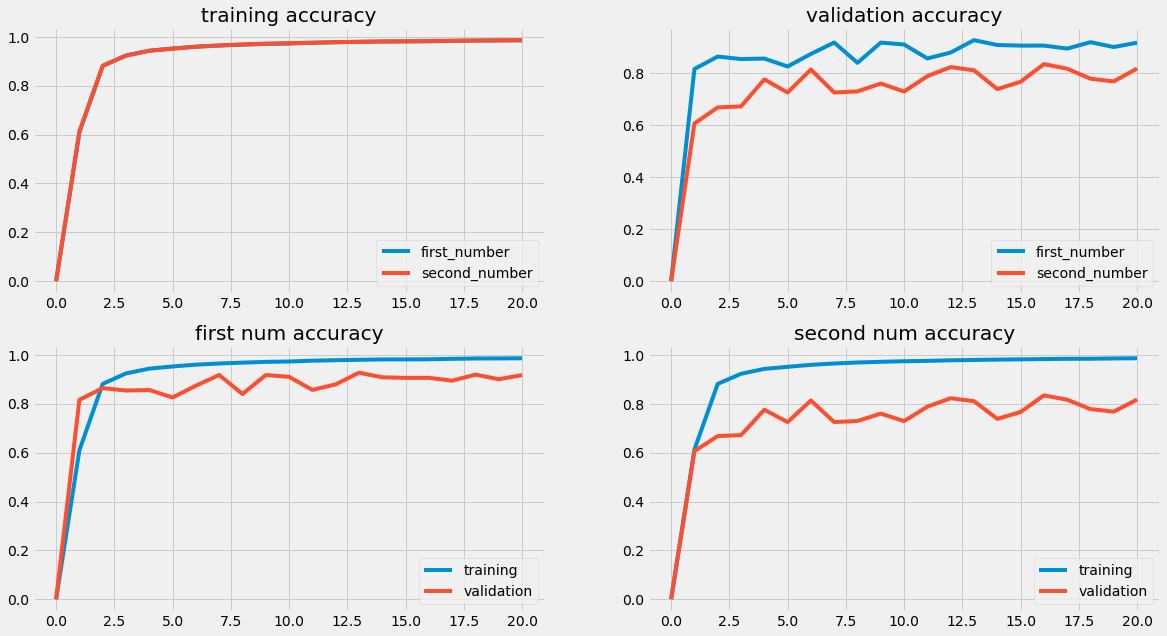

In [41]:
from matplotlib import pyplot as plt
plt.style.use('fivethirtyeight')

fig= plt.figure(figsize=(18,10))

ax1= fig.add_subplot(221)
ax2= fig.add_subplot(222)
ax3= fig.add_subplot(223)
ax4= fig.add_subplot(224)

ax1.plot([0]+history['first_number_accuracy'], label='first_number')
ax1.plot([0]+history['second_number_accuracy'], label='second_number')
ax1.set_title('training accuracy')
ax1.legend()

ax2.plot([0]+history['val_first_number_accuracy'], label='first_number')
ax2.plot([0]+history['val_second_number_accuracy'], label='second_number')
ax2.set_title('validation accuracy')
ax2.legend()

ax3.plot([0]+history['first_number_accuracy'], label='training')
ax3.plot([0]+history['val_first_number_accuracy'], label='validation')
ax3.set_title('first num accuracy')
ax3.legend()

ax4.plot([0]+history['second_number_accuracy'], label='training')
ax4.plot([0]+history['val_second_number_accuracy'], label='validation')
ax4.set_title('second num accuracy')
ax4.legend()

plt.show()

Image-1


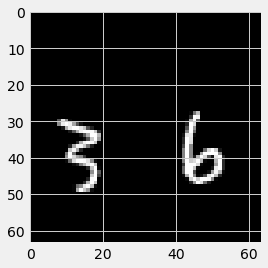

Actual: 36, predict: 36
Image-2


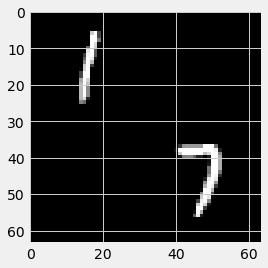

Actual: 17, predict: 19
Image-3


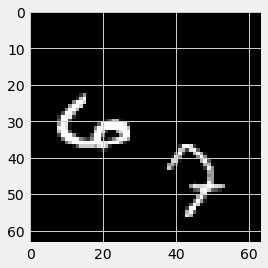

Actual: 67, predict: 62
Image-4


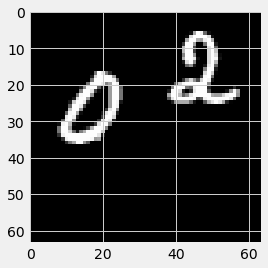

Actual: 02, predict: 02


In [53]:
for i in test_data.take(1):
    for j in range(4):
        print(f'Image-{j+1}')
        plt.imshow(cv.merge((i[0][j].numpy(), i[0][j].numpy(), i[0][j].numpy())))
        plt.show()

        actual= str(i[1]['first_number'][j].numpy())+str(i[1]['second_number'][j].numpy())
        predict= model.predict(tf.expand_dims(i[0][j].numpy(), 0))
        predict= str(np.argmax(predict[0]))+str(np.argmax(predict[1]))

        print(f'Actual: {actual}, predict: {predict}')